# STAT 301 Project Proposal

#### Group 40: Dorothy Ger, Ryan Peng, Sparsh Bajaj, Tony Liang

## 1. Introduction

### 1.1 Background Information on the topic

A motorized vehicle emits around 4.7 tons of carbon dioxide annually (US EPA 2016). To cut down on emissions, bike sharing systems, an innovation from traditional bike rentals, started to emerge as a method of eco-friendly transportation. More than 1000 cities worldwide have implemented a bicycle share program (Lin et al. 2018). From a business perspective, what are factors that effect the number of bicycle rentals became a research area of interest.

### 1.2 The Question

Using the programming language R as a tool for our analysis, we will be attempting to answer the research question: 

   > How are weather patterns statistically significant for predicting number of bike rental counts?


### 1.3 The Dataset

In this report, we will be working on a dataset named “Nike Sharing Dataset” from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), which includes detailed data about rental bikes in Capital bikeshare system. This dataset contains columns with information of: hourly and daily count (`cnt`) of rental bikes, `dates`, `season`, `weather`, etc. We will be looking particularly at which columns can serve as input variables for a predictive model for **daily bike rental counts**. 



## 2. Preliminary Results

### 2.0 Load libraries 

In [28]:
# Load required libraries

import pyplot as plt
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(httr)

ERROR: Error in parse(text = x, srcfile = src): <text>:2:8: unexpected symbol
1: # Load required libraries
2: import pyplot
          ^


### 2.1 Read data and Wrangling

We will first download a zip that contains both hourly and daily data of the bike sharing dataset, and use the **daily bike data** only as mentioned earlier from our introduction, and load it as dataframe. **Note**: The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [3]:
# Downloads zip to tempfile
BIKE_URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
GET(BIKE_URL, write_disk(tf <- tempfile(fileext = ".zip")))
# Unzip tempfile and disgards the hourly data and use daily only
bike_sharing_day <- read_csv(unz(tf, "day.csv"))
# Unlink/remove the temporary file
unlink(tf)
head(bike_sharing_day)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip]
  Date: 2022-12-06 10:17
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 280 kB
<ON DISK>  /tmp/Rtmpj8mVKn/file3529a276dc.zipNULL

Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


Before removing any columns, we are going to get some summary statistics of all variables to check how is the data distributed.

In [4]:
tab <- bike_sharing_day %>%
    select_if(is.numeric) %>%
    pivot_longer(cols = everything(),
                 names_to = "Variable",
                 values_to = "value") %>%
    group_by(Variable) %>%
    summarize(
        Min = round(min(value), 4),
        `1st Quantile` = round(quantile(value, 0.25), 4),
        Mean = round(mean(value), 4),
        Median = round(median(value), 4),
        `3rt Quantile` = round(quantile(value, 0.75), 4),
        Sd = round(sd(value), 4),
        Max = round(max(value), 4))
t(tab)

Variable,atemp,casual,cnt,holiday,hum,instant,mnth,registered,season,temp,weathersit,weekday,windspeed,workingday,yr
Min,0.0791,2.0000,22.0000,0.0000,0.0000,1.0000,1.0000,20.0000,1.0000,0.0591,1.0000,0.0000,0.0224,0.0000,0.0000
1st Quantile,0.3378,315.5000,3152.0000,0.0000,0.5200,183.5000,4.0000,2497.0000,2.0000,0.3371,1.0000,1.0000,0.1349,0.0000,0.0000
Mean,0.4744,848.1765,4504.3488,0.0287,0.6279,366.0000,6.5198,3656.1724,2.4966,0.4954,1.3953,2.9973,0.1905,0.6840,0.5007
Median,0.4867,713.0000,4548.0000,0.0000,0.6267,366.0000,7.0000,3662.0000,3.0000,0.4983,1.0000,3.0000,0.1810,1.0000,1.0000
3rt Quantile,0.6086,1096.0000,5956.0000,0.0000,0.7302,548.5000,10.0000,4776.5000,3.0000,0.6554,2.0000,5.0000,0.2332,1.0000,1.0000
Sd,0.1630,686.6225,1937.2115,0.1672,0.1424,211.1658,3.4519,1560.2564,1.1108,0.1831,0.5449,2.0048,0.0775,0.4652,0.5003
Max,0.8409,3410.0000,8714.0000,1.0000,0.9725,731.0000,12.0000,6946.0000,4.0000,0.8617,3.0000,6.0000,0.5075,1.0000,1.0000


We noticed `temp`, `atemp`, `hum`, `windspeed` are all "normalized" variables given from the originial dataset description according to some transformations. Moreover, we have some time variables like: `weekday`, `mnth`, `dteday`, whereas we are going to discard these for easiness of modelling and not consider it at all when selecting variables. Also, according to the original dataset, we know that `cnt` = `casual` + `registered`, hence this could likely cause collinearity problem later, and we would only focus on `cnt` as a response variable. Also, similar variables like holiday, workingday might have similar issue, hence we would keep one of the two.

In [5]:
# Wrangling data
# Selecting relevant/meaningful columns
# Transform categorical variables to factors
bike_wrangled <- bike_sharing_day %>%
                 select(yr, workingday:windspeed, cnt) %>%
                 mutate(across(yr:weathersit, as.factor))
head(bike_wrangled, 6)

yr,workingday,weathersit,temp,atemp,hum,windspeed,cnt
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,2,0.344167,0.363625,0.805833,0.1604460,985
0,0,2,0.363478,0.353739,0.696087,0.2485390,801
0,1,1,0.196364,0.189405,0.437273,0.2483090,1349
0,1,1,0.200000,0.212122,0.590435,0.1602960,1562
0,1,1,0.226957,0.229270,0.436957,0.1869000,1600
0,1,1,0.204348,0.233209,0.518261,0.0895652,1606


Next, we are also checking if there exist further collinearity problem in the remaining numeric variables by plotting a heat map of these predictors.

In [6]:
# This cell is to control plot size
options(repr.plot.width = 12, repr.plot.height = 12)

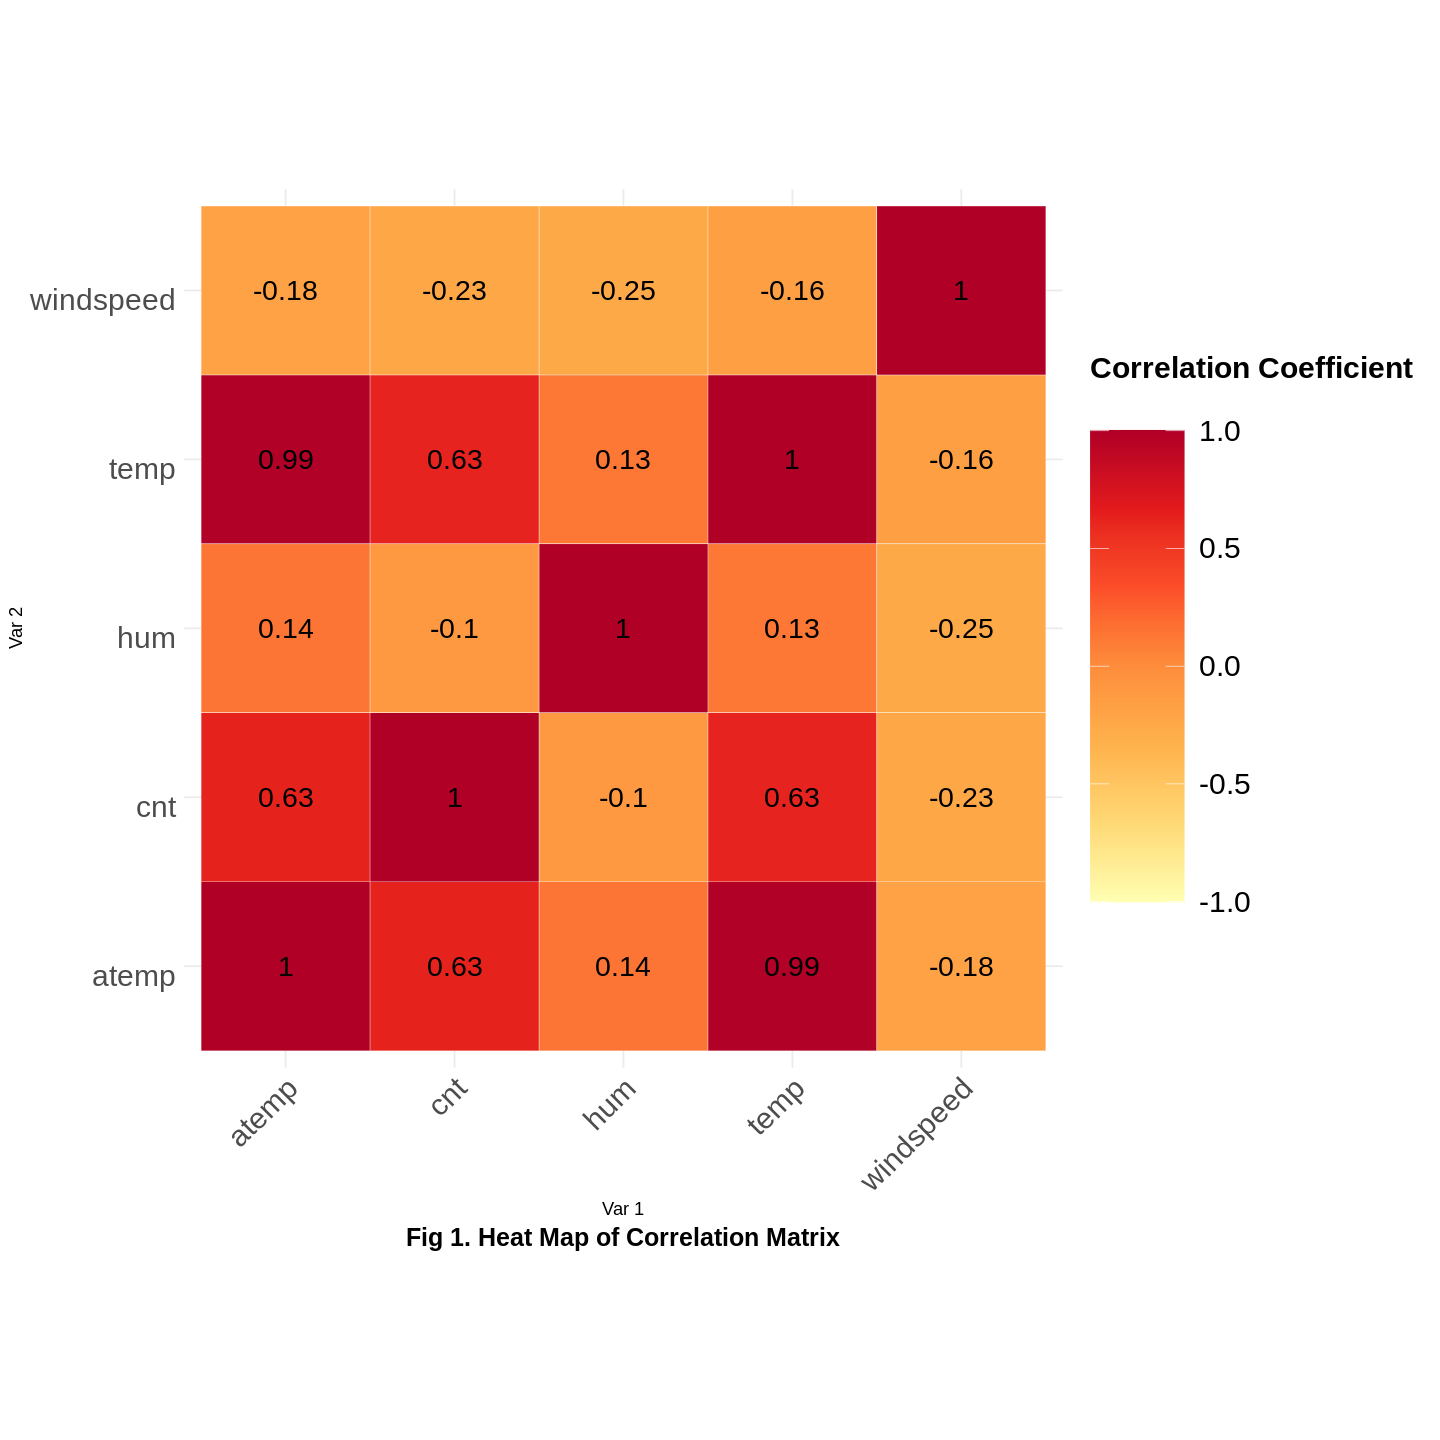

In [43]:
# Correlation marix of numeric predictors
corr_mat <- cor(bike_wrangled %>% select_if(is.numeric)) %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

# Plot heat map of correlation matrix
plot_corr_matrix <- corr_mat %>%
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "Var 1", y = "Var 2", caption = "Fig 1. Heat Map of Correlation Matrix") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm"),
    plot.caption = element_text(size = 15, hjust = 0.5, face = "bold")
  ) +
  coord_fixed() +
  geom_text(aes(x = var1, var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix

We notice `temp` and `atemp` are highly correlated, this indicates that there might exist collinearity between the two variables, which will be handled later.

Now we will visualize the distribution of our response variable, `cnt`, in a histogram first. We can see that the distibution is roughly follows a normal distribution but also have a chance in being multimodal; with a mean of approximately 4500.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



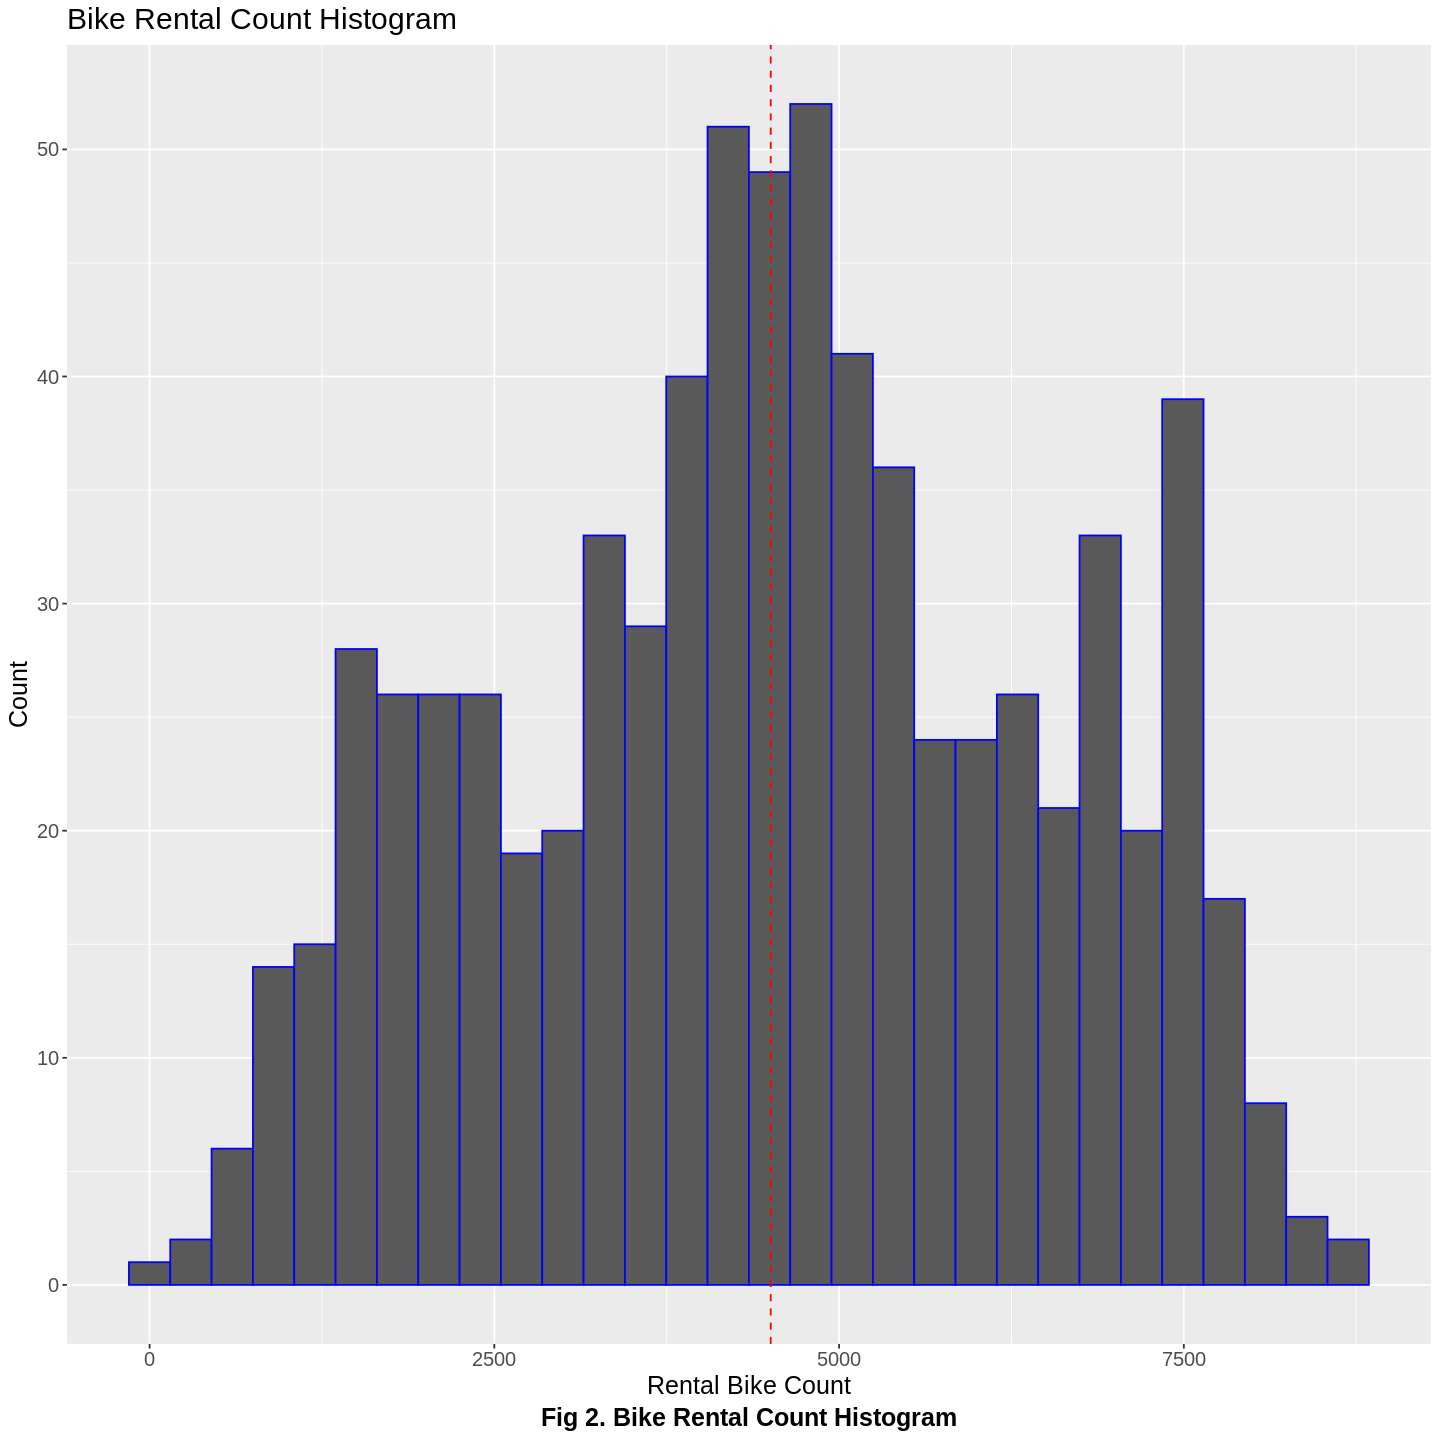

In [42]:
bike_wrangled %>% ggplot(aes(x = cnt)) + 
    geom_histogram(alpha = 2,color = "blue") +
    geom_vline(aes(xintercept=mean(cnt)), color="red",
             linetype="dashed")+
    labs(title="Bike Rental Count Histogram",x="Rental Bike Count", 
         y = "Count", caption = "Fig 2. Bike Rental Count Histogram")+
    theme(text=element_text(size=15), plot.caption = element_text(size = 15, hjust=0.5, face = "bold"))

By creating a Q-Q plot, we can see that some data points deviate away from the 45-degree red line and is therefore a bit heavy-tailed.

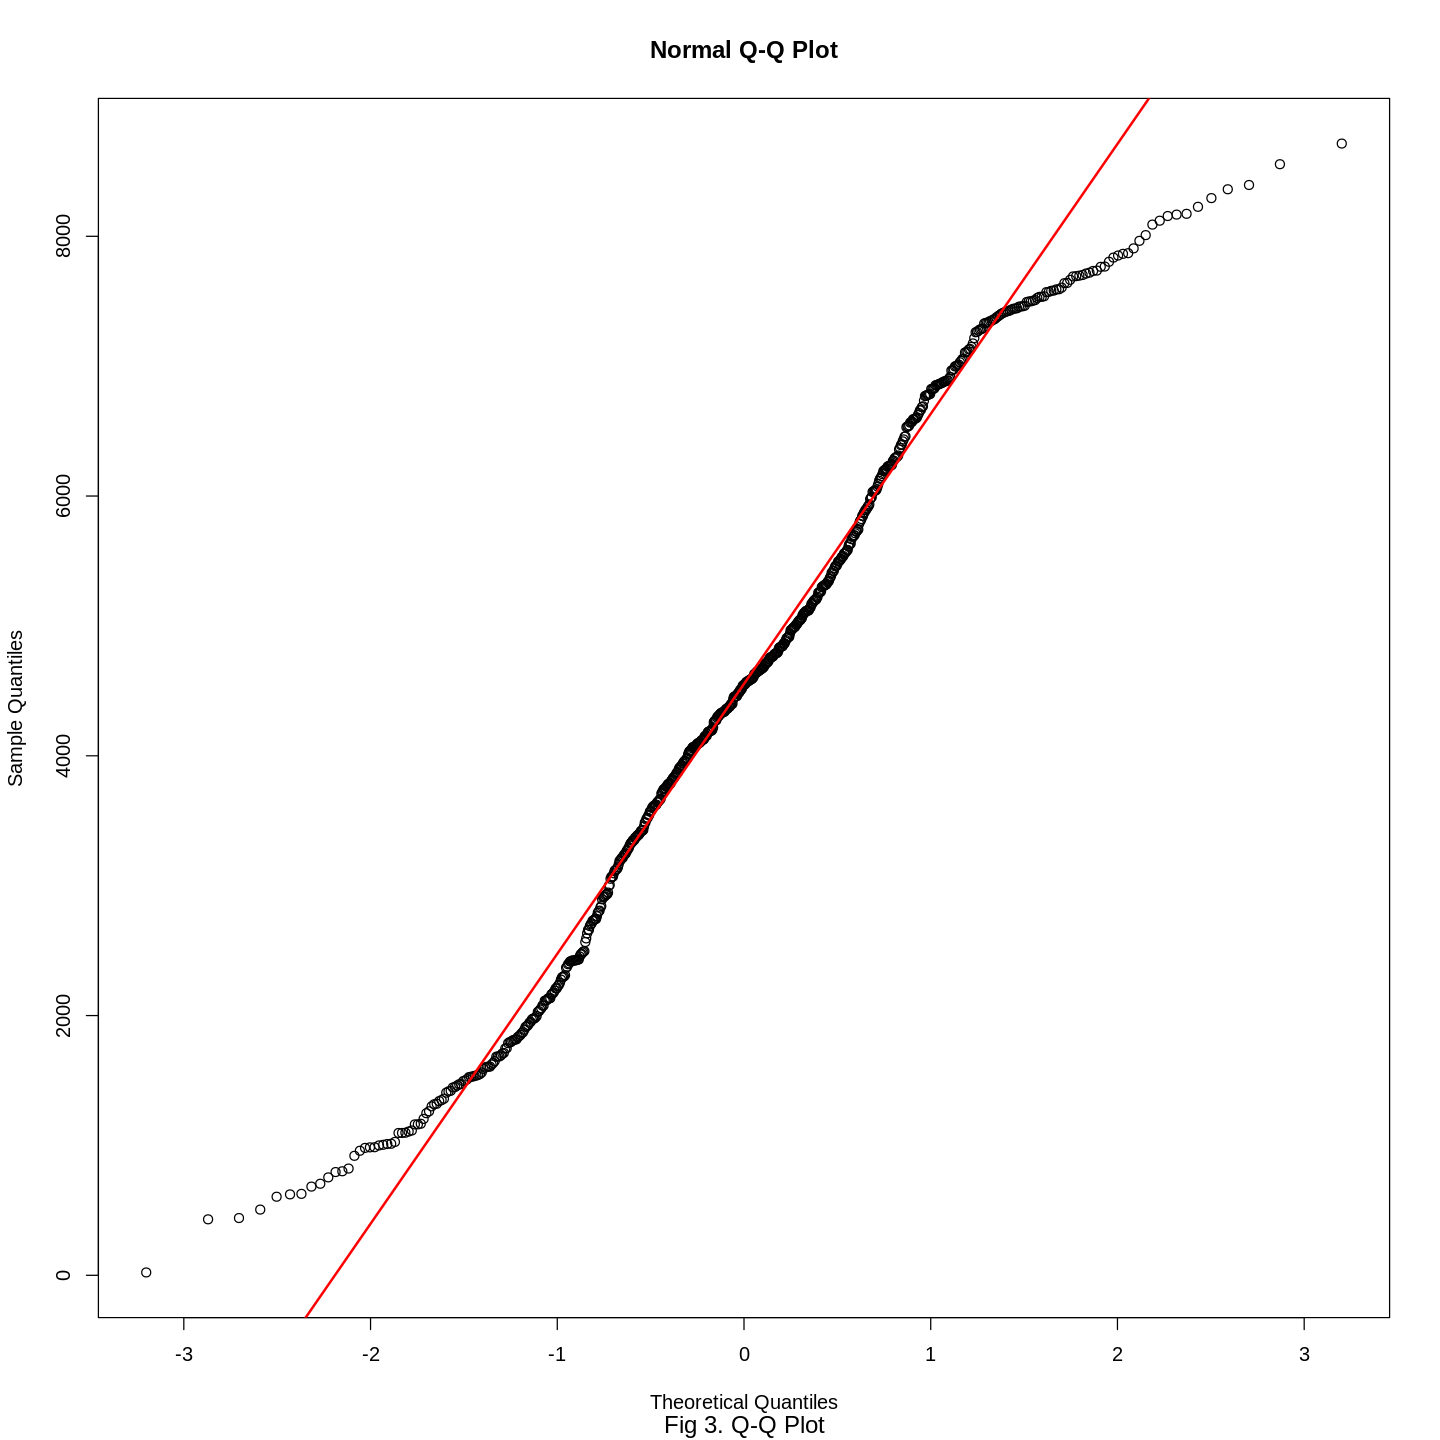

In [72]:
qqnorm(bike_wrangled$cnt)
qqline(bike_wrangled$cnt, col = "red", lwd = 2)
mtext(text = "Fig 3. Q-Q Plot", side=1, line = 4, cex = 1.2)

We then examine the correlation and association between all our variable of interest by using ggpairs

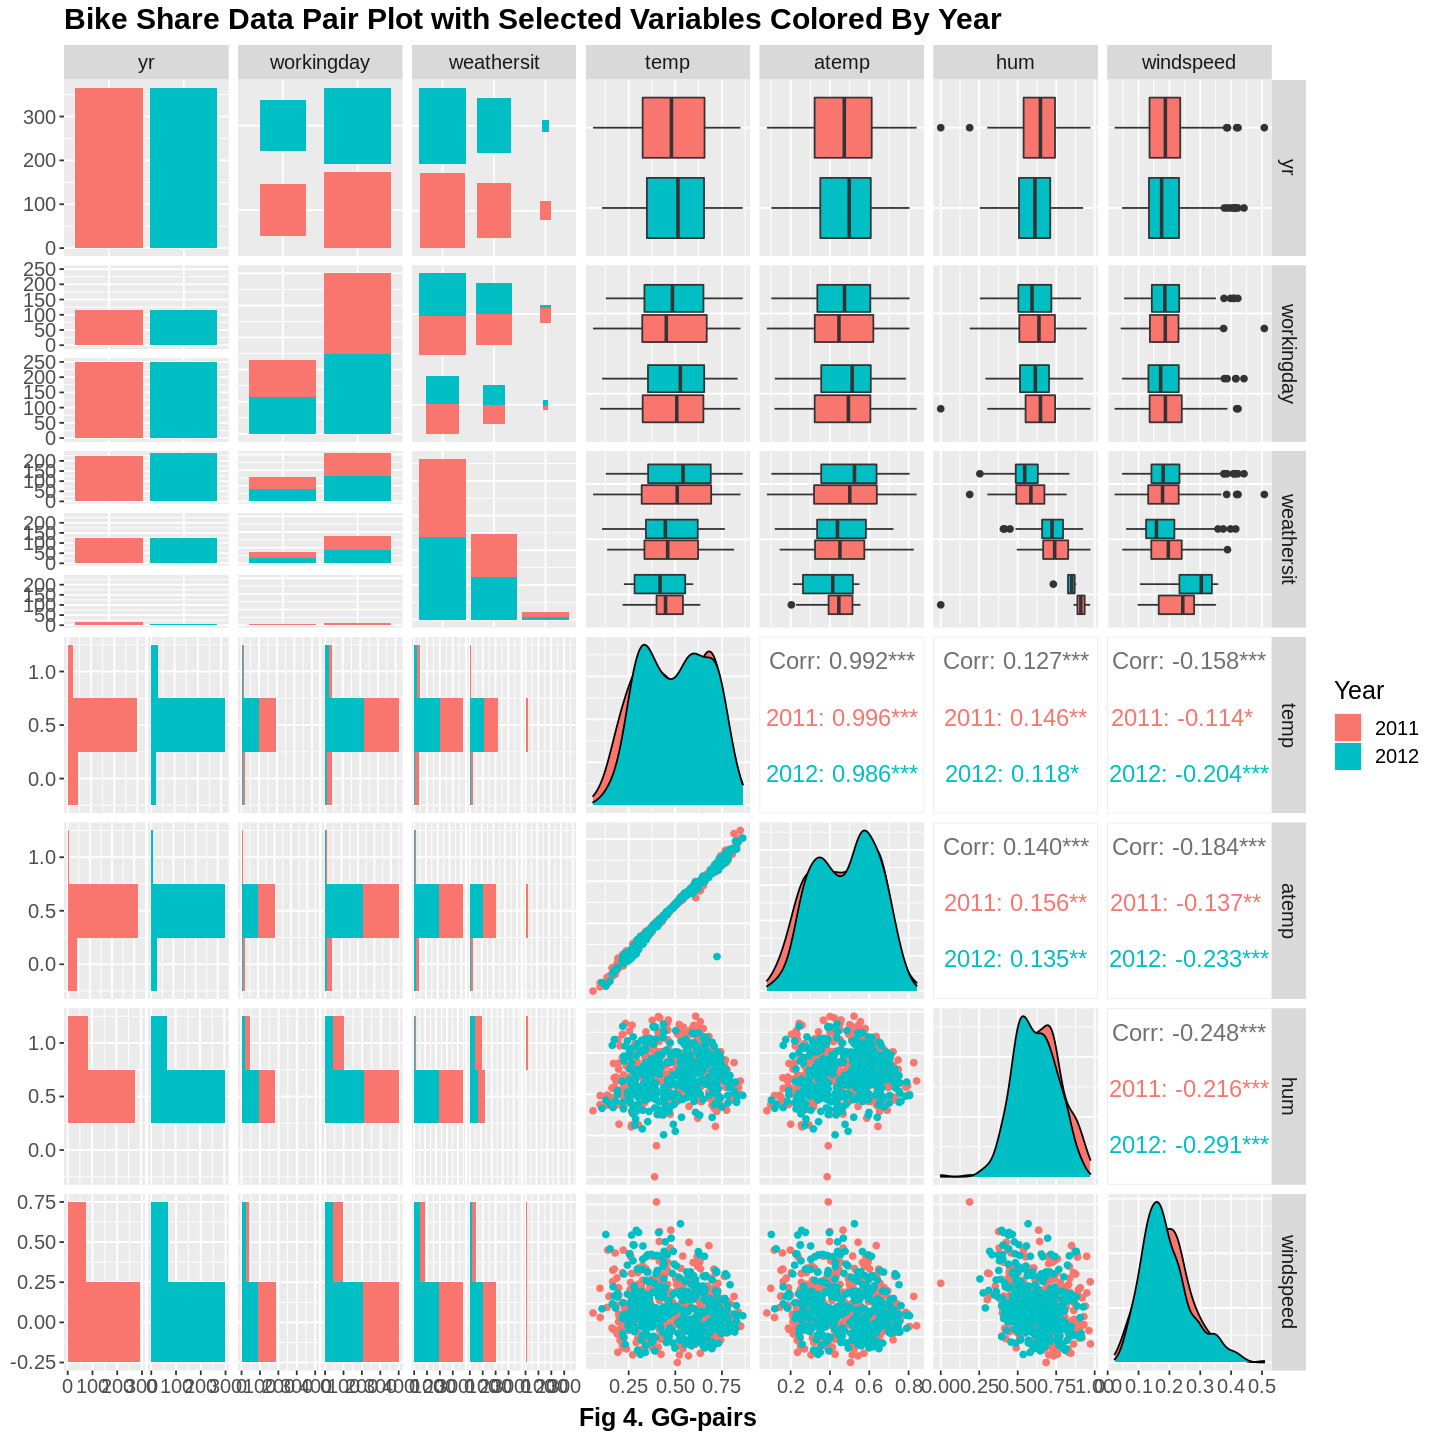

In [47]:
# Visualize the association between our variable of interest (season, workingday, weathersit, 
# temp, atemp, hum, windspeed, cnt)
bs_day_pair_plots <- bike_wrangled %>%
    ggpairs(progress = FALSE, legend = 1, columns = c(1,2,3,4,5,6,7), 
        aes(color = factor(yr, levels = 0:1, labels = c("2011", "2012"))),
        lower=list(combo=wrap("facethist", binwidth=0.5)),
        upper=list(continuous = wrap("cor", size=5))) +
    ggtitle("Bike Share Data Pair Plot with Selected Variables Colored By Year") +
    theme(
        text = element_text(size = 15),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold"),
        plot.caption = element_text(size = 15, hjust = 0.5, face = "bold")
    ) +
    labs(fill = "Year", caption = "Fig 4. GG-pairs")
bs_day_pair_plots

## 3. Methods & Results

### 3.1 Check if Poisson suits the data

For our proposal, we plan to predict the count of bikes using the variable `cnt` by using following predictors: `temp`, `hum`, `windspeed`, `yr`, `workingday`, `weathersit`.  In the proposal stage, we planned to make this prediction using **Poisson Regression** as we believe it can be effectively used for modeling count data (count of bikes, which is discrete). If we assume our different independent predictor variables $x_1$, $x_2$, $x_3$, ..., $x_n$ etc and our response variable (`cnt`) to be $Y$, then our model can be described as shown below: 

$$
\log (\lambda: \mathbb{E}(Y|x)) = \beta_{0} + \beta_{1} x_1 + \beta_{2}x_2 + ... + \beta_{n} x_n.
$$

 Where $\lambda$ is the mean of our observed values $Y_i$, and also its variance, assuming $Y_i \sim \text{Poisson, where}$ $\lambda = \lambda_i $ 
 
 However, does our data satisfy all the assumptions?
 
 The assumptions for Poisson Regression are as follows:
 - the value of our response variable is numeric and positive
 - the mean and variance should be the same 
 - explanatory variables must be continuous, categorical, or binary (dichotomous)
 - observations must be independent
 
 Compare the mean and variance and see if they are roughly the same.

In [26]:
poisson_test <- function(x) 
{

  cat(length(x), " data points.\n",
      "Mean: ",mean(x),"\n",
      "Variance: ",var(x),"\n",
      sep = "")
}

poisson_test(bike_wrangled$cnt)

731 data points.
Mean: 4504.349
Variance: 3752788


 > Based on the results of running our poisson test, we can conclude that since there is a significant diffence in mean and variance, Poisson Regression does not suit our data.

### 3.2 Analysis

### 3.3 Feature Selection

### 3.4 Results

## 4. References

US EPA, O. (2016). *Greenhouse Gas Emissions from a Typical Passenger Vehicle*. US EPA. https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle-0

Lin, L., He, Z., & Peeta, S. (2018). *Predicting station-level hourly demand in a large-scale bike-sharing network: A graph convolutional neural network approach* Transportation Research. Part C, Emerging Technologies, 97, 258-276. https://doi.org/10.1016/j.trc.2018.10.011

Bike Sharing Dataset Data Set . UCI Machine Learning Repository: Bike sharing dataset data set. (n.d.). Retrieved October 31, 2022, from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Zhang, S., He, K., Dong, S., & Zhou, J. (2016, February 15). Modeling the distribution characteristics of urban public bicycle rental duration. Discrete Dynamics in Nature and Society. Retrieved October 26, 2022, from https://www.hindawi.com/journals/ddns/2016/8947525/

Yang, L., Shen, Q., & Li, Z. (2016, July 19). Comparing travel mode and trip chain choices between holidays and weekdays. Transportation Research Part A: Policy and Practice. Retrieved October 26, 2022, from https://www.sciencedirect.com/science/article/pii/S0965856416301781
